# Tải thư viện

In [87]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import LSTM
from keras.layers import Dropout

from keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import pandas_datareader.data as web

# Lấy và xử lý dữ liệu

In [88]:
raw_data = web.DataReader('ACAD',data_source="yahoo",start="01/01/2005",end="01/01/2019").dropna()

In [89]:
raw_data.describe()

,High,Low,Open,Close,Volume,Adj Close
count,3524.000000,3524.000000,3524.000000,3524.000000,3.524000e+03,3524.000000
mean,14.928039,14.196084,14.572279,14.556084,1.232710e+06,14.556084
std,12.755855,12.201520,12.488761,12.481751,2.279983e+06,12.481751
min,0.690000,0.650000,0.650000,0.660000,5.000000e+02,0.660000
25%,2.040000,1.880000,1.960000,1.950000,1.996750e+05,1.950000
50%,11.095000,10.615000,10.910000,10.870000,6.895000e+05,10.870000
75%,24.985000,23.752500,24.382499,24.309999,1.584475e+06,24.309999
max,51.990002,49.700001,50.759998,50.099998,6.010610e+07,50.099998


(3524, 1)             Close
Date             
2004-12-31   6.77
2005-01-03   6.39
2005-01-04   6.28
2005-01-05   6.26
2005-01-06   6.34


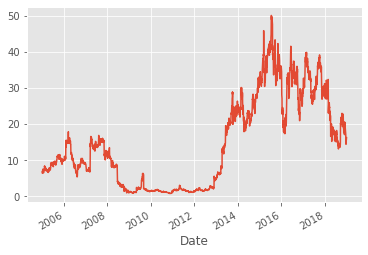

In [90]:
df = raw_data.dropna()
df = df[['Open', 'High', 'Low', 'Close']]
df = df[['Close']]
first_price = df.Close.iloc[0]
print(df.shape, df.head())

df.Close.plot()
def create_ds(ds, look_back):
    dataX, dataY = [], []
    for i in range(len(ds)-look_back-1): 
        data = ds[i:(i+look_back), 0]      
        dataX.append(data)
        dataY.append(ds[i + look_back, 0]) 
    return np.array(dataX), np.array(dataY)

ds = df.values
ds = ds.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
ds = scaler.fit_transform(ds)

## Tách ds thành các tập train và test

In [91]:
#  Chia tập train và tập test theo ty lệ 8 - 2
train_size = int(len(ds) * 0.85)
test_size = len(ds) - train_size
train, test = ds[0:train_size,:], ds[train_size:len(ds)+1,:]

In [92]:
look_back = 10
trainX, trainY = create_ds(train, look_back)
testX, testY = create_ds(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

## Xây dựng model

In [93]:
model = Sequential()
model.add(LSTM(50, activation = 'tanh', input_shape=(look_back,1),return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(20, activation = 'tanh', input_shape=(look_back,1),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(10, activation = 'tanh',return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(1, activation = 'relu'))

In [94]:
opt = Adam(learning_rate=0.0001)
model.compile(optimizer= opt, loss = "mean_squared_error")
start = time.time()
history = model.fit(trainX, trainY, epochs = 50 , batch_size= 32, shuffle=True ,validation_split = 0.15)
print('Thời gian huấn luyện: ', time.time() - start)
model.summary()

Epoch 1/50
80/80 [==============================] - 7s 29ms/step - loss: 0.0428 - val_loss: 0.2375
Epoch 2/50
80/80 [==============================] - 1s 10ms/step - loss: 0.0144 - val_loss: 0.0532
Epoch 3/50
80/80 [==============================] - 1s 10ms/step - loss: 0.0044 - val_loss: 0.0054
Epoch 4/50
80/80 [==============================] - 1s 10ms/step - loss: 0.0020 - val_loss: 0.0059
Epoch 5/50
80/80 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0060
Epoch 6/50
80/80 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 0.0055
Epoch 7/50
80/80 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 0.0057
Epoch 8/50
80/80 [==============================] - 1s 10ms/step - loss: 0.0015 - val_loss: 0.0056
Epoch 9/50
80/80 [==============================] - 1s 10ms/step - loss: 0.0016 - val_loss: 0.0052
Epoch 10/50
80/80 [==============================] - 1s 10ms/step - loss: 0.0014 - val_loss: 0.0057
Epoch 11/

## Sử dụng model để dự đoán kết quả

In [95]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Chỉ số tập train: %.3f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Chỉ số tập test: %.3f RMSE' % (testScore))

17/17 [==============================] - 0s 4ms/step
Chỉ số tập train: 1.779 RMSE
Chỉ số tập test: 2.200 RMSE


## Đồ Thị biểu thị kết quả dự đoán

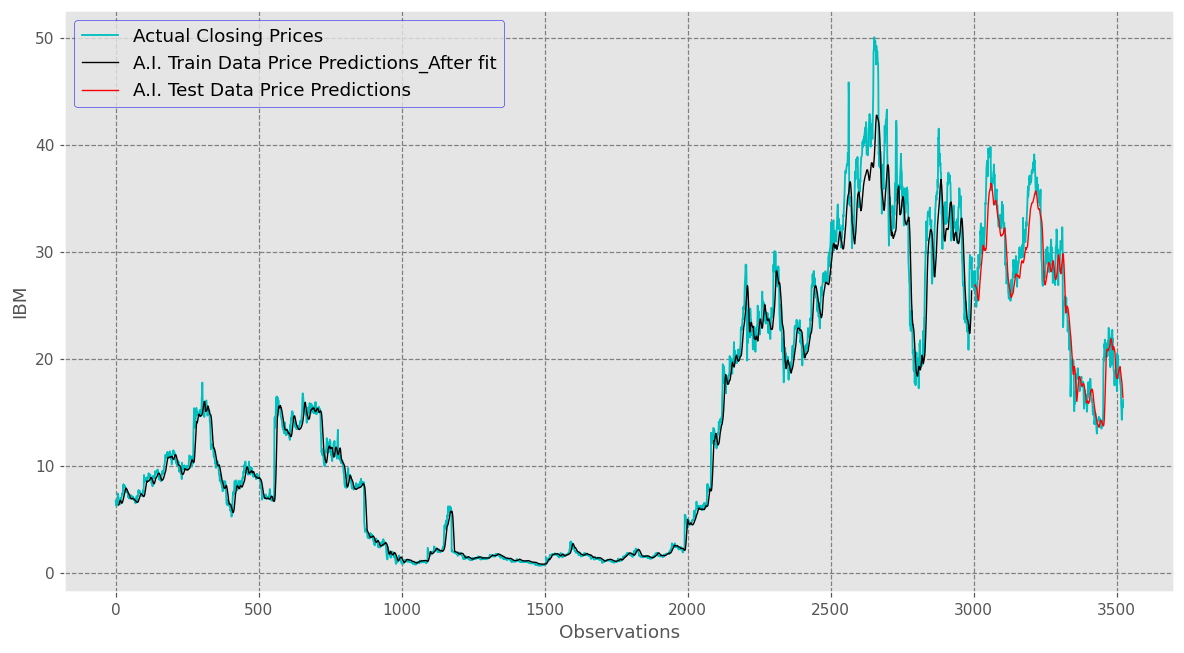

In [96]:
trainPredictPlot = np.empty_like(ds)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(ds)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(ds)-1, :] = testPredict

plt.style.use('ggplot')
plt.figure(figsize=(13,7), dpi=110)
plt.grid(color='grey', linestyle='dashed')
plt.xlabel('Observations')
plt.ylabel('IBM',rotation=90)
plt.plot(scaler.inverse_transform(ds), label = 'Actual Closing Prices', linewidth = 1.2, color = 'c')
plt.plot(trainPredictPlot, label = 'A.I. Train Data Price Predictions_After fit', linewidth = 0.9, color = 'k')
plt.plot(testPredictPlot, label = 'A.I. Test Data Price Predictions', linewidth = 0.9, color = 'r')
legend = plt.legend(fontsize = 12,frameon = True)
legend.get_frame().set_edgecolor('b')
legend.get_frame().set_linewidth(0.4)

plt.show()

In [97]:
model.save('lstm_model.h5')